Pretraining Autoencoder for Downstream Task
=====

## Overview 

In this notebook, we use the pretrained encoder of a mini VGG-based autoencoder as a feature extractor for a neural network.

## Setup 

We setup our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__author__ = 'Abien Fred Agarap'
__version__ = '1.0.0'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tf.vgg_ae import CAE

Set eager mode for `tfds`.

In [2]:
tf.compat.v1.enable_eager_execution()

Set the memory growth of GPU.

In [3]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0],
    True
)

Set the random number generator seed value.

In [4]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

We set the batch size and epochs.

In [5]:
batch_size = 64
epochs = 100

## Dataset

We load the MNIST classification dataset.

In [6]:
train_dataset = tfds.load('emnist/letters', split=tfds.Split.TRAIN)

We define a normalization function.

In [7]:
def normalize(example):    
    features = example['image']
    labels = example['label']
    
    features = tf.cast(features, tf.float32)
    features = features / 255.
    labels = tf.one_hot(labels, 37)
    return features, labels

We customize our `tf.data.Dataset` object.

In [8]:
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Instantiate the mini VGG-based autoencoder model.

In [9]:
model = CAE(input_shape=(28, 28, 1))

Compile the model.

In [10]:
model.compile(loss=tf.losses.mean_squared_error,
              optimizer=tf.optimizers.Adam(learning_rate=1e-3))

Load the trained autoencoder model.

In [11]:
model.load_weights('./assets/export/emnist/mini_vgg_ae_emnist')

In [12]:
test_dataset = tfds.load('emnist/letters',
                         split=tfds.Split.TEST,
                         batch_size=-1)
test_dataset = tfds.as_numpy(test_dataset)
test_features = test_dataset['image']
test_features = test_features.astype('float32') / 255.

Visualize the test data and the model reconstructions.

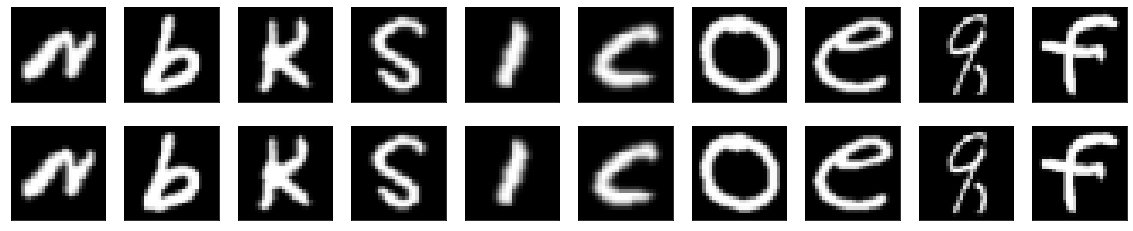

In [13]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    test_image = test_features[index]
    test_image = tf.transpose(test_image)
    test_image = test_image.numpy().reshape(28, 28)
    plt.imshow(test_image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    reconstructed = model(test_image.reshape(-1, 28, 28, 1))
    reconstructed = reconstructed.numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Let's check the number of parameters.

In [14]:
model.summary()

Model: "cae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  64992     
_________________________________________________________________
decoder (Decoder)            multiple                  92609     
Total params: 157,601
Trainable params: 157,601
Non-trainable params: 0
_________________________________________________________________


Freeze the encoder layer of the autoencoder.

In [15]:
model.encoder.trainable = False

Build a neural network with `model.encoder` as feature extractor.

In [16]:
class NN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NN, self).__init__()
        self.encoder = model.encoder
        self.flatten = tf.keras.layers.Flatten()
        self.dense_layer = tf.keras.layers.Dense(units=512, activation=tf.nn.relu)
        self.dropout = tf.keras.layers.Dropout(rate=2e-1)
        self.output_layer = tf.keras.layers.Dense(units=37, activation=tf.nn.softmax)
        
    def call(self, features):
        code = self.encoder(features)
        code = self.flatten(code)
        activation = self.dense_layer(code)
        activation = self.dropout(activation)
        outputs = self.output_layer(activation)
        return outputs

Instantiate the neural network.

In [17]:
clf = NN()

Compile the neural network for training and inference.

In [18]:
clf.compile(loss=tf.losses.categorical_crossentropy,
            optimizer=tf.optimizers.SGD(
                learning_rate=1e-2, momentum=9e-1, decay=1e-6
            ),
            metrics=['accuracy'])

Train the model.

In [19]:
clf.fit(train_dataset, epochs=epochs, verbose=2)

Epoch 1/100
1387/1387 - 22s - loss: 1.1032 - accuracy: 0.6623
Epoch 2/100
1387/1387 - 22s - loss: 0.7901 - accuracy: 0.7528
Epoch 3/100
1387/1387 - 21s - loss: 0.7009 - accuracy: 0.7813
Epoch 4/100
1387/1387 - 21s - loss: 0.6605 - accuracy: 0.7919
Epoch 5/100
1387/1387 - 21s - loss: 0.6324 - accuracy: 0.7997
Epoch 6/100
1387/1387 - 21s - loss: 0.6107 - accuracy: 0.8055
Epoch 7/100
1387/1387 - 21s - loss: 0.5864 - accuracy: 0.8140
Epoch 8/100
1387/1387 - 21s - loss: 0.5701 - accuracy: 0.8182
Epoch 9/100
1387/1387 - 21s - loss: 0.5482 - accuracy: 0.8239
Epoch 10/100
1387/1387 - 23s - loss: 0.5413 - accuracy: 0.8261
Epoch 11/100
1387/1387 - 22s - loss: 0.5316 - accuracy: 0.8297
Epoch 12/100
1387/1387 - 22s - loss: 0.5209 - accuracy: 0.8325
Epoch 13/100
1387/1387 - 21s - loss: 0.5109 - accuracy: 0.8344
Epoch 14/100
1387/1387 - 21s - loss: 0.5066 - accuracy: 0.8361
Epoch 15/100
1387/1387 - 22s - loss: 0.4943 - accuracy: 0.8396
Epoch 16/100
1387/1387 - 21s - loss: 0.4933 - accuracy: 0.8399
E

Evaluate the performance.

In [20]:
test_labels = test_dataset['label']
test_labels = tf.one_hot(test_labels, 37)

clf.evaluate(test_features, test_labels, verbose=2)

14800/1 - 4s - loss: 0.3334 - accuracy: 0.8753


[0.43854039404843304, 0.87533784]

Perturb the test data with noise from a Normal distribution having a standard deviation of `5e-2`.

In [21]:
test_features_raw = test_features

test_features += tf.random.normal(stddev=5e-2, shape=test_features.shape)

Evaluate the model on the perturbed test data.

In [22]:
clf.evaluate(test_features, test_labels, verbose=2)

14800/1 - 4s - loss: 0.9029 - accuracy: 0.7774


[0.9403384916202442, 0.77743244]

Visualize the perturbed data and the reconstructions.

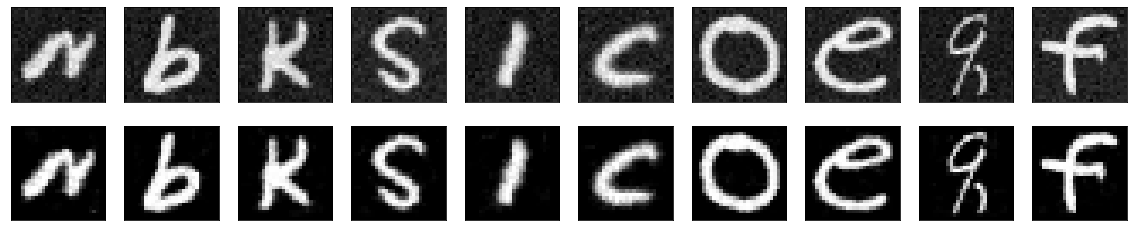

In [23]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    test_image = test_features[index]
    test_image = tf.transpose(test_image)
    test_image = test_image.numpy().reshape(28, 28)
    plt.imshow(test_image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    reconstructed = model(test_image.reshape(-1, 28, 28, 1))
    reconstructed = reconstructed.numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Reload the test features, and increase the standard deviation of the Normal distribution from which we shall get the noise from for perturbing the test data.

In [24]:
test_features = test_features_raw

test_features += tf.random.normal(stddev=5e-1, shape=test_features.shape)

Visualize the test features and the reconstructions.

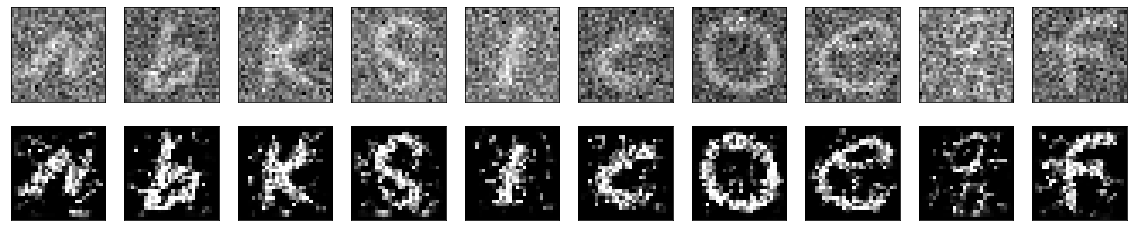

In [25]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    test_image = test_features[index]
    test_image = tf.transpose(test_image)
    test_image = test_image.numpy().reshape(28, 28)
    plt.imshow(test_image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    reconstructed = model(test_image.reshape(-1, 28, 28, 1))
    reconstructed = reconstructed.numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Evaluate on the new perturbed test data.

In [26]:
clf.evaluate(test_features, test_labels, verbose=2)

14800/1 - 4s - loss: 16.5316 - accuracy: 0.2354


[18.47456665451462, 0.2354054]

In [27]:
model.save_weights('../assets/export/classifier/emnist/100_epochs', save_format='tf')